# Deploycamp Group 12 - Fraud Data Machine Learning Pipeline

## Import Required Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import joblib

from scipy.stats import ttest_ind

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)

## Dataset Selection & EDA

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fraud_detection.csv to fraud_detection (1).csv


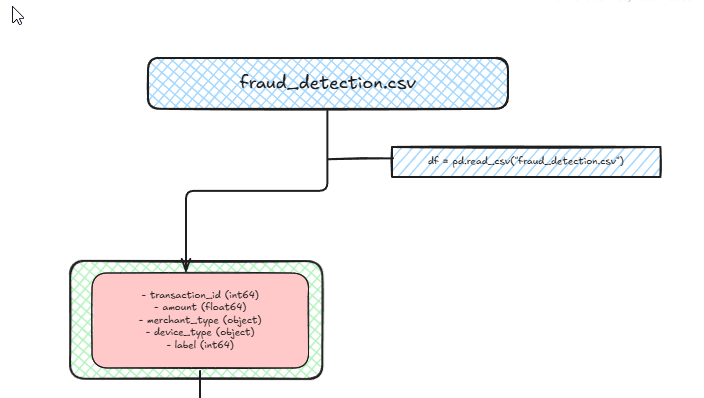

We skipped the EDA process because it's already done in another notebook

In [ ]:
df = pd.read_csv("fraud_detection.csv") #getting file name
df[df['label']==1].head()

,transaction_id,amount,merchant_type,device_type,label
36,37,36.33,clothing,mobile,1
59,60,39.35,clothing,desktop,1
76,77,147.52,electronics,tablet,1
86,87,130.79,electronics,mobile,1
91,92,124.91,groceries,tablet,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


In [ ]:
print(f"Jenis Merchant: {df['merchant_type'].unique()}")
print(f"Jenis Device  : {df['device_type'].unique()}")
print(f"Jenis Label   : {df['label'].unique()}")

Jenis Merchant: ['travel' 'groceries' 'others' 'electronics' 'clothing']
Jenis Device  : ['tablet' 'desktop' 'mobile']
Jenis Label   : [0 1]


In [ ]:
def modus_data(x):
    modes = x.mode()
    return modes[0] if not modes.empty else np.nan

label_numerik = df.groupby('label')['amount'].describe()
print(label_numerik)

print()
print(df.groupby('label')['amount'].agg(['mean', 'median', 'std', 'count', ('mode', modus_data)]))

group0 = df[df['label'] == 0]['amount']
group1 = df[df['label'] == 1]['amount']
print()
print("Uji-t p-value:", ttest_ind(group0, group1).pvalue.round(2))
print()

print(df.groupby('merchant_type')['amount'].agg(['mean', 'median', 'std', 'count', ('mode', modus_data)]))
print()
print(df.groupby('device_type')['amount'].agg(['mean', 'median', 'std', 'count', ('mode', modus_data)]))

print()
group00 = df[df['device_type'] == 'mobile']['amount']
group11 = df[df['device_type'] == 'desktop']['amount']
group12 = df[df['device_type'] == 'tablet']['amount']
print()

pval_mobile_vs_desktop = ttest_ind(group00, group11).pvalue.round(2)
pval_mobile_vs_tablet = ttest_ind(group00, group12).pvalue.round(2)
pval_desktop_vs_tablet = ttest_ind(group11, group12).pvalue.round(2)

print("Mobile vs Desktop:", pval_mobile_vs_desktop)
print("Mobile vs Tablet:", pval_mobile_vs_tablet)
print("Desktop vs Tablet:", pval_desktop_vs_tablet)
print()

       count  mean   std  min   25%   50%    75%    max
label                                                  
0     950.00 97.59 98.16 0.46 26.10 68.38 137.00 817.24
1      50.00 90.86 78.44 3.76 32.93 78.72 128.25 431.55

       mean  median   std  count  mode
label                                 
0     97.59   68.38 98.16    950  2.57
1     90.86   78.72 78.44     50  3.76

Uji-t p-value: 0.63

                mean  median   std  count  mode
merchant_type                                  
clothing       95.70   68.31 99.08    212 27.08
electronics   101.29   76.05 98.62    193  0.55
groceries      95.20   69.00 94.81    173 29.83
others         90.95   54.82 96.76    214  4.16
travel        103.27   73.65 97.03    208  2.57

              mean  median    std  count  mode
device_type                                   
desktop      94.35   69.94  99.01    321  2.57
mobile       97.08   66.73  91.45    346 67.85
tablet      100.23   68.42 101.51    333 29.83


Mobile vs Desktop: 0.71

In [ ]:
print(f"Mean     : {df['amount'].mean():.2f}  | Mean ≠ Median adalah distribusi miring (skewed).")
print(f"Median   : {df['amount'].median():.2f}  | Mean ≠ Median adalah distribusi miring (skewed).")
print(f"Mode     : {df['amount'].mode()[0]:.2f}   | Mode jauh dari Mean/Median adalah distribusi multimodal.")
print(f"Variansi : {df['amount'].var():.0f}   | semakin besar, semakin tersebar.")
print(f"Std Dev  : {df['amount'].std():.2f}  | semakin besar, semakin tersebar.")
print(f"Skewness : {df['amount'].skew():.2f}   | lebih dari 1 makin lebar ekor ke kanan.")

Mean     : 97.25  | Mean ≠ Median adalah distribusi miring (skewed).
Median   : 68.68  | Mean ≠ Median adalah distribusi miring (skewed).
Mode     : 2.57   | Mode jauh dari Mean/Median adalah distribusi multimodal.
Variansi : 9458   | semakin besar, semakin tersebar.
Std Dev  : 97.25  | semakin besar, semakin tersebar.
Skewness : 1.87   | lebih dari 1 makin lebar ekor ke kanan.


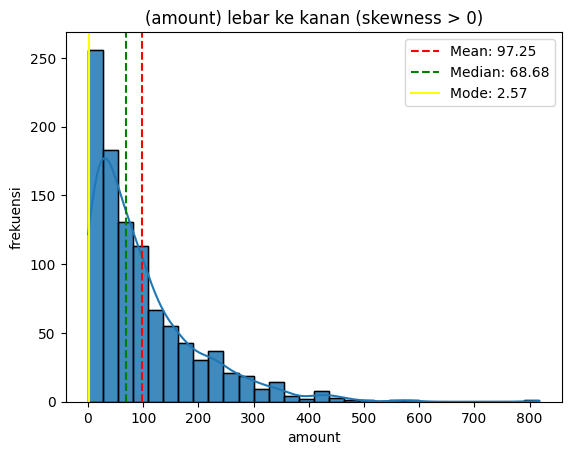

In [ ]:
plt.hist(df['amount'], bins=30, edgecolor='black', alpha=0.7)
plt.title('(amount) lebar ke kanan (skewness > 0)')
plt.xlabel('amount')
plt.ylabel('frekuensi')
sns.histplot(df['amount'], kde=True, bins=30)
plt.axvline(np.mean(df['amount']), color='red', linestyle='dashed', label=f'Mean: {np.mean(df["amount"]):.2f}')
plt.axvline(np.median(df['amount']), color='green', linestyle='dashed', label=f'Median: {np.median(df["amount"]):.2f}')
plt.axvline(df['amount'].mode()[0], color='yellow', label=f'Mode: {df["amount"].mode()[0]:.2f}')
plt.legend()
plt.show()

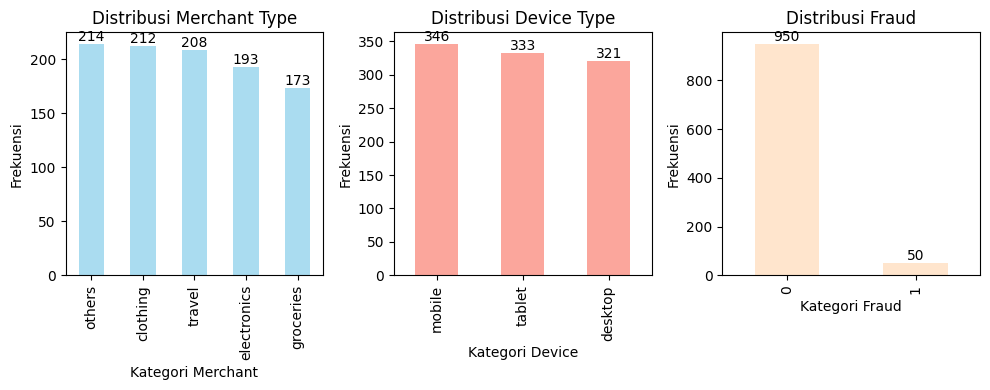

In [ ]:
from os import device_encoding
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

merchant_counts = df['merchant_type'].value_counts()
merchant_plot = merchant_counts.plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Distribusi Merchant Type')
axes[0].set_xlabel('Kategori Merchant')
axes[0].set_ylabel('Frekuensi')

for i, count in enumerate(merchant_counts):
    axes[0].text(i, count + 0.1, str(count), ha='center', va='bottom')

#-----------------------------------------------------------#

device_counts = df['device_type'].value_counts()
device_plot = device_counts.plot(kind='bar', ax=axes[1], color='salmon', alpha=0.7)
axes[1].set_title('Distribusi Device Type')
axes[1].set_xlabel('Kategori Device')
axes[1].set_ylabel('Frekuensi')

for i, count in enumerate(device_counts):
    axes[1].text(i, count + 0.1, str(count), ha='center', va='bottom')

#-----------------------------------------------------------#

label_counts = df['label'].value_counts()
label_plot = label_counts.plot(kind='bar', ax=axes[2], color='peachpuff', alpha=0.7)
axes[2].set_title('Distribusi Fraud')
axes[2].set_xlabel('Kategori Fraud')
axes[2].set_ylabel('Frekuensi')

for i, count in enumerate(label_counts):
    axes[2].text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
fraud_crosstab = pd.crosstab(
    index=df[df['label'] == 1]['merchant_type'],
    columns=df[df['label'] == 1]['device_type'],
    margins=True  #add total
)
print(fraud_crosstab)

device_type    desktop  mobile  tablet  All
merchant_type                              
clothing             5       2       2    9
electronics          1       4       6   11
groceries            1       2       3    6
others               5       7       4   16
travel               2       4       2    8
All                 14      19      17   50


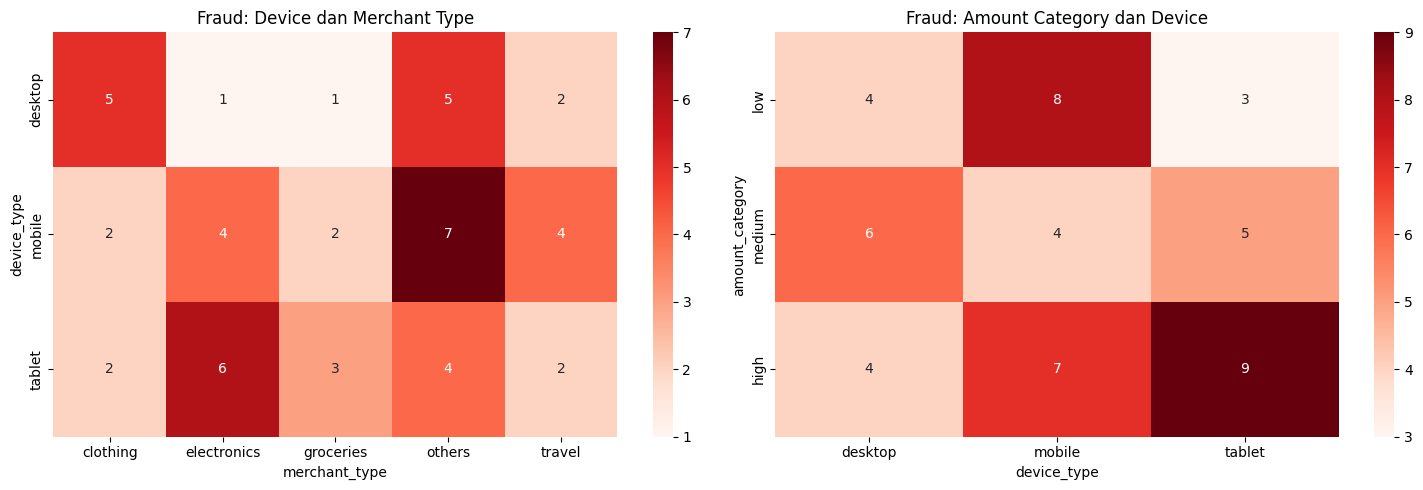

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1 baris, 2 kolom

fraud_pivot = df[df['label'] == 1].pivot_table(
    index='device_type',
    columns='merchant_type',
    values='label',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(fraud_pivot, annot=True, fmt='d', cmap='Reds', ax=ax1)
ax1.set_title('Fraud: Device dan Merchant Type')

fraud_pivot2 = df[df['label'] == 1].pivot_table(
    index='amount_category',
    columns='device_type',
    values='label',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(fraud_pivot2, annot=True, fmt='d', cmap='Reds', ax=ax2)
ax2.set_title('Fraud: Amount Category dan Device')

plt.tight_layout()
plt.show()

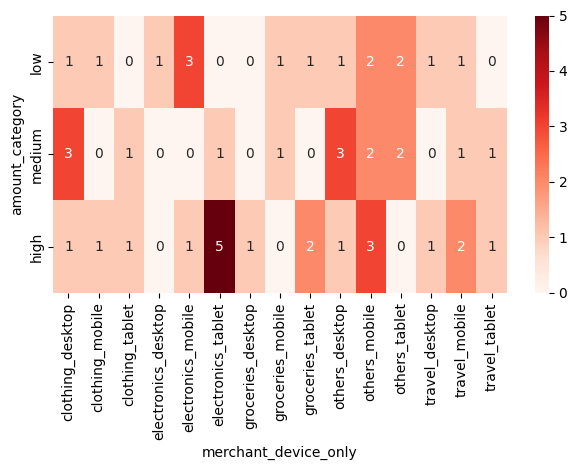

In [ ]:
fraud_pivot3 = df[df['label'] == 1].pivot_table(
    index='amount_category',
    columns='merchant_device_only',
    values='label',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(fraud_pivot3, annot=True, fmt='d', cmap='Reds')
# sns.set_title('Fraud: Amount Category dan Combined')

plt.tight_layout()
plt.show()

### Feature Engineering

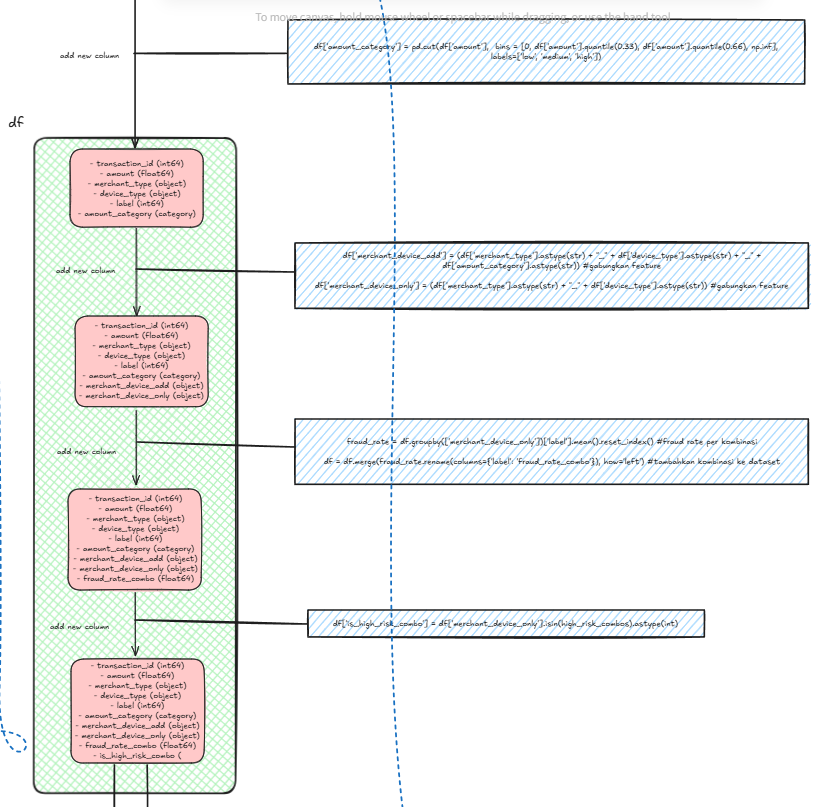

In [ ]:
# Feature Engineering Pipeline

# Custom Transformer to combine features
# This transformer takes the original DataFrame and adds new columns
# by combining existing categorical features, including calculating amount_category.
class FeatureCombiner(BaseEstimator, TransformerMixin):
    # The fit method doesn't need to do anything for this transformer
    def fit(self, X, y=None):
        return self

    # The transform method creates the new combined features and calculates amount_category
    def transform(self, X):
        # Create a copy of the input DataFrame to avoid modifying the original
        X_transformed = X.copy()

        # Calculate amount_category
        X_transformed['amount_category'] = pd.cut(X_transformed['amount'], bins = [0, X_transformed['amount'].quantile(0.33), X_transformed['amount'].quantile(0.66), np.inf], labels=['low', 'medium', 'high'])


        # Combine 'merchant_type', 'device_type', and 'amount_category'
        X_transformed['merchant_device_add'] = (X_transformed['merchant_type'].astype(str) + "_" +
                                                X_transformed['device_type'].astype(str) + "_" +
                                                X_transformed['amount_category'].astype(str))
        # Combine 'merchant_type' and 'device_type'
        X_transformed['merchant_device_only'] = (X_transformed['merchant_type'].astype(str) + "_" +
                                                 X_transformed['device_type'].astype(str))
        return X_transformed

# Custom Transformer to calculate Fraud Rate per Combination
# This transformer calculates the mean fraud rate for each unique
# 'merchant_device_only' combination based on the training data (y).
class FraudRateCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize a dictionary to store the calculated fraud rates
        self.fraud_rate_map = None

    # The fit method calculates the fraud rate for each combination
    def fit(self, X, y):
        df_temp = X.copy()
        df_temp['label'] = y
        self.fraud_rate_map = df_temp.groupby('merchant_device_only')['label'].mean().to_dict()
        return self

    # The transform method maps the calculated fraud rates to the DataFrame
    def transform(self, X):
        X_transformed = X.copy()
        # Map the fraud rate to the 'merchant_device_only' column
        # Fill any missing values (for combinations not seen during training) with 0
        X_transformed['fraud_rate_combo'] = X_transformed['merchant_device_only'].map(self.fraud_rate_map).fillna(0)
        return X_transformed

# Custom Transformer to create High Risk Combo Indicator
# This transformer identifies the 'merchant_device_only' combinations
# with a fraud rate above a certain quantile threshold and creates a
# binary indicator column.
class HighRiskIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, quantile_threshold=0.85):
        # Initialize the quantile threshold
        self.quantile_threshold = quantile_threshold
        # Initialize a list to store the high-risk combinations
        self.high_risk_combos = None

    # The fit method identifies the high-risk combinations based on the fraud rate
    def fit(self, X, y=None):
        # Assuming 'fraud_rate_combo' is already calculated and present in X
        if 'fraud_rate_combo' not in X.columns:
             raise ValueError("'fraud_rate_combo' column is required for HighRiskIndicator.")

        threshold = X['fraud_rate_combo'].quantile(self.quantile_threshold)
        self.high_risk_combos = X[X['fraud_rate_combo'] >= threshold]['merchant_device_only'].unique().tolist()
        return self

    # The transform method creates the 'is_high_risk_combo' indicator column.
    # It also drops the intermediate 'amount_category' column as it's now included
    # in 'merchant_device_add' and not needed separately for the final model input.
    def transform(self, X):
        X_transformed = X.copy()
        # Create the binary indicator column: 1 if the combo is in the high-risk list, 0 otherwise
        X_transformed['is_high_risk_combo'] = X_transformed['merchant_device_only'].isin(self.high_risk_combos).astype(int)
        # Drop amount_category as it's incorporated into merchant_device_add
        return X_transformed


# Create the feature engineering pipeline
# This pipeline combines the custom transformers to perform the feature engineering steps sequentially.
feature_engineering_pipeline = Pipeline([
    ('combiner', FeatureCombiner()), # Step 1: Combine features and calculate amount_category
    ('fraud_rate_calc', FraudRateCalculator()), # Step 2: Calculate fraud rate per combination
    ('high_risk_indicator', HighRiskIndicator(quantile_threshold=0.85)) # Step 3: Create high-risk indicator and drop amount_category
])

# Fit and transform the data using the refactored pipeline
# We fit the pipeline on the training data (excluding the target 'label') and the target variable 'label'
# The pipeline learns the fraud rates and high-risk combinations during the fit step
# Then, it transforms the data by applying the defined feature engineering steps
df_engineered = feature_engineering_pipeline.fit_transform(df.drop('label', axis=1), df['label'])

# Display the first few rows of the engineered DataFrame to see the results
display(df_engineered.head())

,transaction_id,amount,merchant_type,device_type,amount_category,merchant_device_add,merchant_device_only,fraud_rate_combo,is_high_risk_combo
0,1,46.93,travel,tablet,medium,travel_tablet_medium,travel_tablet,0.03,0
1,2,301.01,groceries,desktop,high,groceries_desktop_high,groceries_desktop,0.02,0
2,3,131.67,others,tablet,high,others_tablet_high,others_tablet,0.06,0
3,4,91.29,electronics,desktop,medium,electronics_desktop_medium,electronics_desktop,0.02,0
4,5,16.96,others,mobile,low,others_mobile_low,others_mobile,0.10,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   transaction_id        1000 non-null   int64   
 1   amount                1000 non-null   float64 
 2   merchant_type         1000 non-null   object  
 3   device_type           1000 non-null   object  
 4   label                 1000 non-null   int64   
 5   amount_category       1000 non-null   category
 6   merchant_device_add   1000 non-null   object  
 7   merchant_device_only  1000 non-null   object  
 8   fraud_rate_combo      1000 non-null   float64 
 9   is_high_risk_combo    1000 non-null   int64   
dtypes: category(1), float64(2), int64(3), object(4)
memory usage: 71.5+ KB


In [ ]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   transaction_id        1000 non-null   int64   
 1   amount                1000 non-null   float64 
 2   merchant_type         1000 non-null   object  
 3   device_type           1000 non-null   object  
 4   amount_category       1000 non-null   category
 5   merchant_device_add   1000 non-null   object  
 6   merchant_device_only  1000 non-null   object  
 7   fraud_rate_combo      1000 non-null   float64 
 8   is_high_risk_combo    1000 non-null   int64   
dtypes: category(1), float64(2), int64(2), object(4)
memory usage: 63.7+ KB


## Preprocessing & Splitting Data

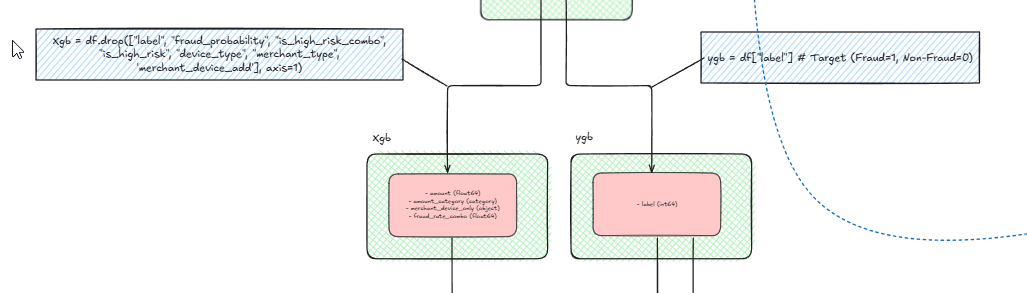

Xgb & ygb

In [ ]:
Xgb = df_engineered.drop(["transaction_id", "is_high_risk_combo", "device_type", "merchant_type", 'merchant_device_add'], axis=1)

In [ ]:
Xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   amount                1000 non-null   float64 
 1   amount_category       1000 non-null   category
 2   merchant_device_only  1000 non-null   object  
 3   fraud_rate_combo      1000 non-null   float64 
dtypes: category(1), float64(2), object(1)
memory usage: 24.7+ KB


In [ ]:
ygb = df["label"] # Target (Fraud=1, Non-Fraud=0)

In [ ]:
ygb.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: label
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB


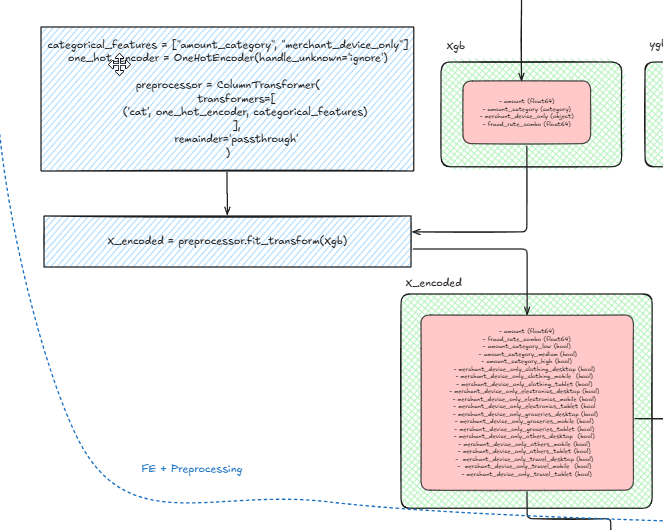

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["amount_category", "merchant_device_only"]
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features)
    ],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(Xgb)

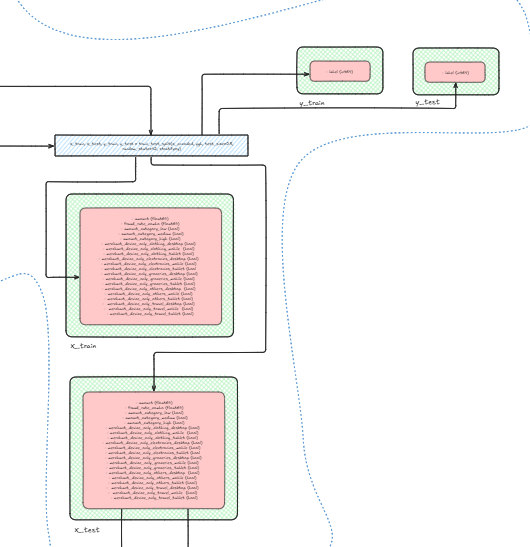

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, ygb, test_size=0.5, random_state=42, stratify=ygb)

## Resample Dataset, Apply SMOTE, and Model Training

 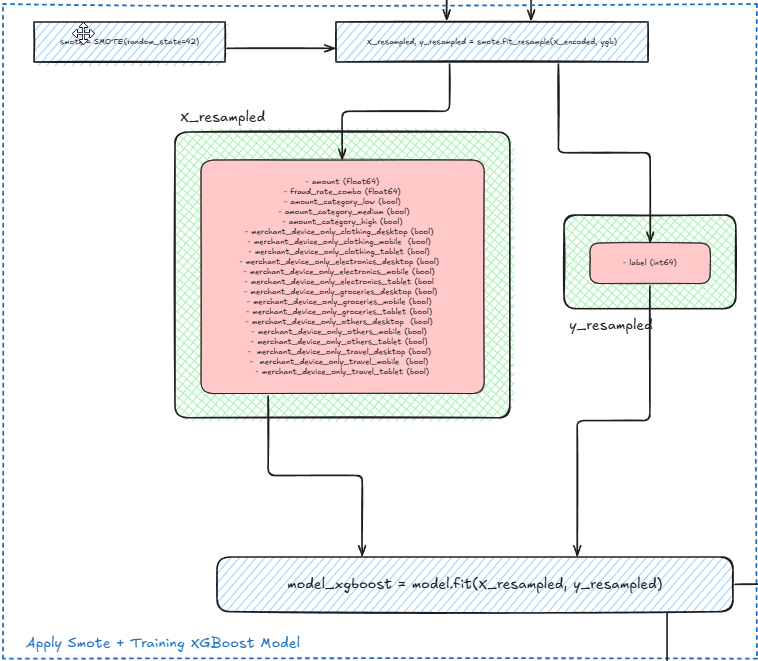

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
X_resampled, y_resampled = smote.fit_resample(X_encoded, ygb)

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(19.0)

In [ ]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Critical for imbalanced data
    objective="binary:logistic",
    random_state=42,
    eval_metric="aucpr"  # Use AUC-PR for imbalanced problems
)

In [ ]:
model_xgboost = model.fit(X_resampled, y_resampled)

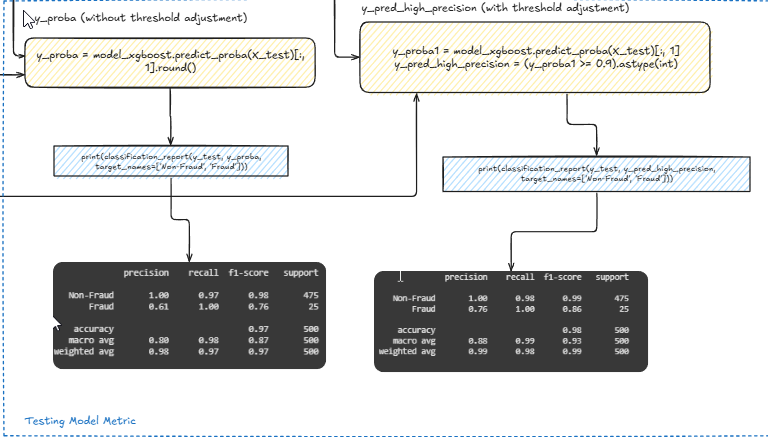

In [ ]:
from sklearn.metrics import classification_report

y_proba = model_xgboost.predict_proba(X_test)[:, 1].round()
print(classification_report(y_test, y_proba, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.96      0.98       475
       Fraud       0.56      1.00      0.71        25

    accuracy                           0.96       500
   macro avg       0.78      0.98      0.85       500
weighted avg       0.98      0.96      0.97       500



In [ ]:
y_proba1 = model_xgboost.predict_proba(X_test)[:, 1]
y_pred_high_precision = (y_proba1 >= 0.88).astype(int)

print(classification_report(y_test, y_pred_high_precision, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99       475
       Fraud       0.73      0.96      0.83        25

    accuracy                           0.98       500
   macro avg       0.86      0.97      0.91       500
weighted avg       0.98      0.98      0.98       500



In [ ]:
y_proba1 = model_xgboost.predict_proba(X_test)[:, 1]
y_pred_high_precision = (y_proba1 >= 0.9).astype(int)

print(classification_report(y_test, y_pred_high_precision, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.99      0.99       475
       Fraud       0.79      0.92      0.85        25

    accuracy                           0.98       500
   macro avg       0.89      0.95      0.92       500
weighted avg       0.99      0.98      0.98       500



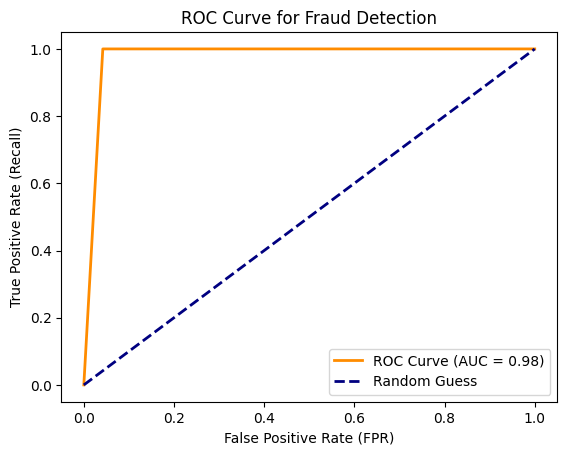

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Fraud Detection')
plt.legend()
plt.show()

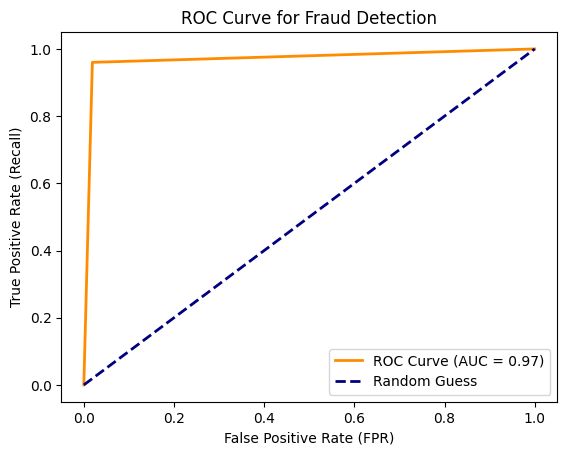

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_high_precision)
roc_auc = roc_auc_score(y_test, y_pred_high_precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Fraud Detection')
plt.legend()
plt.show()

In [ ]:
import joblib

# Define the filenames for the pickle files
pipeline_filename = 'feature_engineering_pipeline.pkl'
model_filename = 'best_xgboost_model.pkl' # Or a more descriptive name

# Save the feature engineering pipeline
joblib.dump(feature_engineering_pipeline, pipeline_filename)

# Save the trained XGBoost model
joblib.dump(model_xgboost, model_filename)

print(f"Feature engineering pipeline saved to {pipeline_filename}")
print(f"XGBoost model saved to {model_filename}")

Feature engineering pipeline saved to feature_engineering_pipeline.pkl
XGBoost model saved to best_xgboost_model.pkl


## Experiment Summary

This notebook details an experiment in fraud detection.

**1. Data Loading and Initial Exploration:**
- The `fraud_detection.csv` dataset was loaded into a pandas DataFrame.
- Initial inspection using `.head()` and `.info()` was performed.

**2. Feature Engineering:**
- A new categorical feature `amount_category` was created by binning the `amount` feature into 'low', 'medium', and 'high'.
- New features `merchant_device_add` and `merchant_device_only` were created by combining existing categorical features.
- `fraud_rate_combo` was calculated as the mean fraud rate for each unique `merchant_device_only` combination and merged back into the DataFrame.
- `is_high_risk_combo` was created based on a threshold of the `fraud_rate_combo`.

**3. Data Preparation for Modeling:**
- Features (`Xgb`) and the target variable (`ygb`) were separated.
- Categorical features (`amount_category`, `merchant_device_only`) were one-hot encoded using `OneHotEncoder`.
- The data was split into training and testing sets.
- SMOTE was applied to the training data to address class imbalance.

**4. Model Training:**
- An XGBoost classifier was initialized with `scale_pos_weight` to handle class imbalance and `eval_metric="aucpr"`.
- The model was trained on the SMOTE-resampled data.

**5. Model Evaluation:**
- The model's performance was evaluated using a classification report on the test set. Initially, predictions were made by rounding the probabilities (`y_proba`), resulting in high recall for the fraud class but lower precision.
- A custom threshold of 0.89 was applied to the predicted probabilities (`y_proba1`) to achieve higher precision, as shown in a second classification report.
- ROC curves were plotted for both prediction methods (rounding probabilities and using the 0.88 threshold) to visualize the trade-off between True Positive Rate and False Positive Rate, with corresponding AUC scores displayed.

**Overall:** The experiment demonstrates a workflow for fraud detection including feature engineering, handling class imbalance with SMOTE, training an XGBoost model, and evaluating performance with different prediction thresholds to optimize for either recall or precision.

## MLFlow Task
Log experiment for different threshold to mlflow in a custom server.

### Install mlflow

#### Subtask:
Install the MLflow library.


**Reasoning**:
The subtask is to install the MLflow library. The instruction specifically asks to use `pip install mlflow` in a code cell.



In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 14.8 MB/s eta 0:00:00


### Set up mlflow tracking uri

#### Subtask:
Configure MLflow to connect to your custom tracking server.


**Reasoning**:
Configure MLflow to connect to the custom tracking server.



In [ ]:
import mlflow

mlflow.set_tracking_uri("https://103-150-90-187.sslip.io/mlflow")
mlflow.set_experiment("fraud_detection_")

<Experiment: artifact_location='/scripts/mlflow-artifacts', creation_time=1754402730794, experiment_id='8', last_update_time=1754402730794, lifecycle_stage='active', name='fraud_detection_', tags={'mlflow.note.content': 'Testing description'}>

### Iterate through different thresholds

#### Subtask:
Loop through a range of thresholds for your model's predictions.


**Reasoning**:
Define a range of thresholds to evaluate the model's performance and initiate a loop to iterate through them.



In [ ]:
thresholds = np.arange(0.5, 1.01, 0.02)

for threshold in thresholds:
    print(f"Evaluating with threshold: {threshold:.2f}")
    # Subsequent steps for evaluation and logging will go here

Evaluating with threshold: 0.50
Evaluating with threshold: 0.52
Evaluating with threshold: 0.54
Evaluating with threshold: 0.56
Evaluating with threshold: 0.58
Evaluating with threshold: 0.60
Evaluating with threshold: 0.62
Evaluating with threshold: 0.64
Evaluating with threshold: 0.66
Evaluating with threshold: 0.68
Evaluating with threshold: 0.70
Evaluating with threshold: 0.72
Evaluating with threshold: 0.74
Evaluating with threshold: 0.76
Evaluating with threshold: 0.78
Evaluating with threshold: 0.80
Evaluating with threshold: 0.82
Evaluating with threshold: 0.84
Evaluating with threshold: 0.86
Evaluating with threshold: 0.88
Evaluating with threshold: 0.90
Evaluating with threshold: 0.92
Evaluating with threshold: 0.94
Evaluating with threshold: 0.96
Evaluating with threshold: 0.98
Evaluating with threshold: 1.00


### Log parameters and metrics for each threshold

#### Subtask:
Within the loop, start an MLflow run, log the current threshold as a parameter, calculate relevant evaluation metrics (e.g., precision, recall, F1-score) for that threshold, and log these metrics to MLflow. End the MLflow run.


**Reasoning**:
Implement the core logic of the subtask within the loop: start an MLflow run, log the threshold, calculate metrics, and log metrics.



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = np.arange(0.5, 1.01, 0.02)

for threshold in thresholds:
    print(f"Evaluating with threshold: {threshold:.2f}")
    with mlflow.start_run(run_name=f"XGBoost with Threshold {threshold:.2f}"):
        mlflow.log_param("threshold", threshold)

        y_proba1 = model_xgboost.predict_proba(X_test)[:, 1]
        y_pred = (y_proba1 >= threshold).astype(int)

        report = classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'], output_dict=True)

        fraud_precision = report['Fraud']['precision']
        fraud_recall = report['Fraud']['recall']
        fraud_f1 = report['Fraud']['f1-score']

        print(f"Precision : {fraud_precision:.2f}")
        print(f"Recall : {fraud_recall:.2f}")
        print(f"F1-Score : {fraud_f1:.2f}")
        print("logging to mlflow .. ")

        mlflow.log_metric("fraud_precision", fraud_precision)
        mlflow.log_metric("fraud_recall", fraud_recall)
        mlflow.log_metric("fraud_f1_score", fraud_f1)

        # Calculate and print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print("")
        print(cm)
        print("")

        # Optional: Log confusion matrix as an artifact (requires saving it as an image or text file)
        # For simplicity, we'll just print it here.

        print("logging done !")
        print("=======================")


print("all experiment has been logged to mlflow !")

Evaluating with threshold: 0.50
Precision : 0.56
Recall : 1.00
F1-Score : 0.71
logging to mlflow .. 
Confusion Matrix:
[[455  20]
 [  0  25]]
logging done !
🏃 View run XGBoost with Threshold 0.50 at: https://103-150-90-187.sslip.io/mlflow/#/experiments/8/runs/29209d0b6161421fbf623694f078b79e
🧪 View experiment at: https://103-150-90-187.sslip.io/mlflow/#/experiments/8
Evaluating with threshold: 0.52
Precision : 0.58
Recall : 1.00
F1-Score : 0.74
logging to mlflow .. 
Confusion Matrix:
[[457  18]
 [  0  25]]
logging done !
🏃 View run XGBoost with Threshold 0.52 at: https://103-150-90-187.sslip.io/mlflow/#/experiments/8/runs/b34a211a7c5e4612bfd5474b28fa6d3b
🧪 View experiment at: https://103-150-90-187.sslip.io/mlflow/#/experiments/8
Evaluating with threshold: 0.54
Precision : 0.61
Recall : 1.00
F1-Score : 0.76
logging to mlflow .. 
Confusion Matrix:
[[459  16]
 [  0  25]]
logging done !
🏃 View run XGBoost with Threshold 0.54 at: https://103-150-90-187.sslip.io/mlflow/#/experiments/8/runs/

## Project Structure for FastAPI
Python code for each flow in FastAPI. Folder Structure will be something like this :

```
fraud_detection_project/
├── data/
│   └── fraud_detection.csv  # Your raw data file
├── notebooks/
│   └── your_analysis_notebook.ipynb  # Your current Colab notebook
├── src/
│   ├── __init__.py
│   ├── features.py      # Custom transformers (FeatureCombiner, FraudRateCalculator, HighRiskIndicator)
│   ├── pipeline.py      # Code to build the full preprocessing pipeline (including OneHotEncoder and feature engineering)
│   ├── model.py         # Code for model training and saving
│   └── predict.py       # Code for loading the pipeline/model and making predictions (used by the API)
├── api/
│   └── app.py           # Your FastAPI application code
├── models/
│   ├── feature_engineering_pipeline.pkl  # Saved feature engineering pipeline
│   └── best_xgboost_model.pkl         # Saved trained model
├── requirements.txt     # List of Python dependencies
└── README.md            # Project description and instructions
```

Here is the code for `__init__.py`. This file is typically empty but is needed to treat the `src` directory as a Python package.

In [ ]:
# src/__init__.py

# This file makes the 'src' directory a Python package.
# It can be left empty.
pass

Here is the code for `features.py`. This file contains the custom transformers for your feature engineering steps.

In [ ]:
# src/features.py

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Custom Transformer to combine features
class FeatureCombiner(BaseEstimator, TransformerMixin):
    """
    A custom transformer to combine existing categorical features into new ones.
    """
    def fit(self, X, y=None):
        """
        Fit method. Does nothing for this transformer.
        """
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame by adding combined feature columns.
        """
        X_transformed = X.copy()
        X_transformed['amount_category'] = pd.cut(X_transformed['amount'], bins = [0, X_transformed['amount'].quantile(0.33), X_transformed['amount'].quantile(0.66), np.inf], labels=['low', 'medium', 'high'])


        X_transformed['merchant_device_add'] = (X_transformed['merchant_type'].astype(str) + "_" +
                                                X_transformed['device_type'].astype(str) + "_" +
                                                X_transformed['amount_category'].astype(str))
        X_transformed['merchant_device_only'] = (X_transformed['merchant_type'].astype(str) + "_" +
                                                 X_transformed['device_type'].astype(str))
        return X_transformed

# Custom Transformer to calculate Fraud Rate per Combination
class FraudRateCalculator(BaseEstimator, TransformerMixin):
    """
    A custom transformer to calculate the mean fraud rate for each unique
    'merchant_device_only' combination based on the training data (y).
    """
    def __init__(self):
        """
        Initializes the FraudRateCalculator with an empty fraud rate map.
        """
        self.fraud_rate_map = None

    def fit(self, X, y):
        """
        Calculates the fraud rate for each 'merchant_device_only' combination.
        """
        df_temp = X.copy()
        df_temp['label'] = y
        self.fraud_rate_map = df_temp.groupby('merchant_device_only')['label'].mean().to_dict()
        return self

    def transform(self, X):
        """
        Maps the calculated fraud rates to the 'fraud_rate_combo' column.
        """
        X_transformed = X.copy()
        X_transformed['fraud_rate_combo'] = X_transformed['merchant_device_only'].map(self.fraud_rate_map).fillna(0)
        return X_transformed

# Custom Transformer to create High Risk Combo Indicator
class HighRiskIndicator(BaseEstimator, TransformerMixin):
    """
    A custom transformer to identify high-risk 'merchant_device_only' combinations
    based on a fraud rate quantile threshold and create a binary indicator column.
    """
    def __init__(self, quantile_threshold=0.85):
        """
        Initializes the HighRiskIndicator with a quantile threshold.
        """
        self.quantile_threshold = quantile_threshold
        self.high_risk_combos = None

    def fit(self, X, y=None):
        """
        Identifies the high-risk 'merchant_device_only' combinations.
        """
        # Assuming 'fraud_rate_combo' is already calculated and present in X
        if 'fraud_rate_combo' not in X.columns:
             raise ValueError("'fraud_rate_combo' column is required for HighRiskIndicator.")

        threshold = X['fraud_rate_combo'].quantile(self.quantile_threshold)
        self.high_risk_combos = X[X['fraud_rate_combo'] >= threshold]['merchant_device_only'].unique().tolist()
        return self

    def transform(self, X):
        """
        Creates the 'is_high_risk_combo' indicator column.
        """
        X_transformed = X.copy()
        X_transformed['is_high_risk_combo'] = X_transformed['merchant_device_only'].isin(self.high_risk_combos).astype(int)
        return X_transformed

Here is the code for `model.py`. This file contains the logic for training and saving your model.

In [ ]:
# src/model.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import mlflow
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Import custom feature engineering transformers
from src.features import FeatureCombiner, FraudRateCalculator, HighRiskIndicator

def train_and_log_model(df: pd.DataFrame, mlflow_tracking_uri: str, experiment_name: str, best_threshold: float):
    """
    Trains the XGBoost model, logs metrics to MLflow, and saves the pipeline and model.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        mlflow_tracking_uri (str): The MLflow tracking URI.
        experiment_name (str): The name of the MLflow experiment.
        best_threshold (float): The chosen threshold for prediction.
    """
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment(experiment_name)

    # Define features (X) and target (y)
    X = df.drop('label', axis=1)
    y = df['label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

    # --- Feature Engineering and Preprocessing Pipeline ---
    # This pipeline includes the custom feature engineering steps and one-hot encoding.
    # SMOTE is applied separately to the training data after this pipeline.

    # Define preprocessing steps for numerical and categorical features
    numerical_features = ['amount'] # 'fraud_rate_combo' will be generated by the pipeline
    categorical_features = ["merchant_type", "device_type", "amount_category"] # These are used in feature engineering

    # Create transformers for categorical features
    # The FeatureCombiner and FraudRateCalculator will add 'merchant_device_only' and 'fraud_rate_combo'
    # OneHotEncoder will then be applied to the relevant categorical features *after* feature engineering.
    # We need to carefully construct the pipeline to ensure features are available when needed.

    # Let's define the full preprocessing pipeline including feature engineering and encoding
    full_preprocessing_pipeline = Pipeline([
        ('combiner', FeatureCombiner()),
        ('fraud_rate_calc', FraudRateCalculator()),
        ('high_risk_indicator', HighRiskIndicator(quantile_threshold=0.85)),
        ('column_transformer', ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), ["amount_category", "merchant_device_only"]) # One-hot encode the relevant features *after* creation
            ],
            remainder='passthrough' # Keep other columns like 'amount', 'fraud_rate_combo', 'is_high_risk_combo'
        ))
    ])

    # Fit and transform the training data using the full preprocessing pipeline
    X_train_processed = full_preprocessing_pipeline.fit_transform(X_train, y_train)

    # Apply SMOTE to the processed training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

    # --- Model Training ---
    # Calculate scale_pos_weight for XGBoost
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Initialize and train the XGBoost model
    model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        objective="binary:logistic",
        random_state=42,
        eval_metric="aucpr"
    )
    model_xgboost = model.fit(X_resampled, y_resampled)

    # --- Evaluation and MLflow Logging ---
    with mlflow.start_run():
        mlflow.log_param("best_threshold", best_threshold)
        mlflow.log_param("smote_random_state", 42)
        mlflow.log_param("xgb_scale_pos_weight", scale_pos_weight)

        # Transform the test data using the fitted preprocessing pipeline (without SMOTE)
        X_test_processed = full_preprocessing_pipeline.transform(X_test)

        # Predict probabilities on the test set
        y_proba = model_xgboost.predict_proba(X_test_processed)[:, 1]

        # Apply the best threshold to get binary predictions
        y_pred = (y_proba >= best_threshold).astype(int)

        # Calculate evaluation metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f"Metrics for threshold {best_threshold:.2f}:")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1-Score: {f1:.2f}")
        print("Confusion Matrix:")
        print(cm)

        # Log metrics to MLflow
        mlflow.log_metric("test_precision", precision)
        mlflow.log_metric("test_recall", recall)
        mlflow.log_metric("test_f1_score", f1)
        # You can log confusion matrix as an artifact if needed

        # Log the full preprocessing pipeline and the trained model
        # We save the full pipeline up to the point before the model for inference.
        # The model is saved separately.
        joblib.dump(full_preprocessing_pipeline, '../models/full_preprocessing_pipeline.pkl')
        joblib.dump(model_xgboost, '../models/best_xgboost_model.pkl')

        mlflow.log_artifact('../models/full_preprocessing_pipeline.pkl')
        mlflow.log_artifact('../models/best_xgboost_model.pkl')

    print("Model training, logging, and saving complete.")

if __name__ == '__main__':
    # Example usage (assuming df is loaded in the notebook)
    # You would call this function from your notebook or another script
    # train_and_log_model(df, "https://103-150-90-187.sslip.io/mlflow", "fraud_detection_api_training", 0.88)
    print("model.py is intended to be imported and run, not executed directly.")
    print("Load your data and call the 'train_and_log_model' function.")

Here is the code for `predict.py`. This file contains functions for loading the saved pipeline and model and making predictions on new data.

In [ ]:
# src/predict.py

import joblib
import pandas as pd
import numpy as np

# Define the path where the pipeline and model are saved
PIPELINE_PATH = '../models/full_preprocessing_pipeline.pkl'
MODEL_PATH = '../models/best_xgboost_model.pkl'

# Load the saved pipeline and model (load once when the module is imported)
try:
    loaded_pipeline = joblib.load(PIPELINE_PATH)
    loaded_model = joblib.load(MODEL_PATH)
    print("Preprocessing pipeline and model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Ensure '{PIPELINE_PATH}' and '{MODEL_PATH}' exist.")
    loaded_pipeline = None
    loaded_model = None

def make_prediction(data: dict, threshold: float) -> bool:
    """
    Makes a fraud prediction on new data using the loaded pipeline and model.

    Args:
        data (dict): A dictionary containing the input transaction data.
                     Expected keys: 'amount', 'merchant_type', 'device_type', 'amount_category'.
                     Note: 'fraud_rate_combo' is calculated by the pipeline.
        threshold (float): The prediction probability threshold.

    Returns:
        bool: True if the prediction is fraud, False otherwise.
    """
    if loaded_pipeline is None or loaded_model is None:
        print("Error: Model or pipeline not loaded. Cannot make prediction.")
        return False # Or raise an exception

    try:
        # Convert input data to a pandas DataFrame
        # Ensure the input data matches the structure expected by the pipeline before feature engineering
        # The required columns before the pipeline are: 'amount', 'merchant_type', 'device_type', 'amount_category'
        input_df = pd.DataFrame([data])

        # Apply the full preprocessing pipeline to the input data
        # Note: SMOTE is part of the training pipeline, but the loaded pipeline here
        # is the 'full_preprocessing_pipeline' which does not include SMOTE.
        # The 'full_preprocessing_pipeline' should handle feature engineering and encoding.
        processed_data = loaded_pipeline.transform(input_df)

        # Make prediction using the loaded model
        # The model expects the output of the preprocessing pipeline
        y_proba = loaded_model.predict_proba(processed_data)[:, 1]
        prediction = (y_proba >= threshold).astype(int)[0]

        return bool(prediction)

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return False # Or raise the exception

if __name__ == '__main__':
    # Example usage
    # This part will run only if you execute predict.py directly

    # Example data for prediction (replace with actual data structure)
    example_data = {
        'amount': 50.0,
        'merchant_type': 'electronics',
        'device_type': 'mobile',
        'amount_category': 'medium' # Ensure this is included if your pipeline uses it
    }

    # Replace with your best threshold
    prediction_threshold = 0.88

    is_fraud = make_prediction(example_data, prediction_threshold)

    if is_fraud:
        print(f"Transaction is predicted as FRAUD (Threshold: {prediction_threshold})")
    else:
        print(f"Transaction is predicted as NON-FRAUD (Threshold: {prediction_threshold})")

Here is the code for `app.py`. This file defines the FastAPI application and uses the `predict.py` module to make predictions.

In [ ]:
# api/app.py

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import sys
import os

# Add the src directory to the Python path to import modules
sys.path.append(os.path.join(os.path.dirname(__file__), '..', 'src'))

from predict import make_prediction

# Define the threshold based on your MLflow experiments
# Replace with the actual best threshold found in your experiment
PREDICTION_THRESHOLD = 0.88

app = FastAPI()

# Define the expected structure of the input data using Pydantic
class TransactionInput(BaseModel):
    amount: float
    merchant_type: str
    device_type: str


@app.get("/")
def read_root():
    """
    Basic endpoint to check if the API is running.
    """
    return {"message": "Fraud Detection API is running!"}

@app.post("/predict")
def predict_fraud(transaction: TransactionInput):
    """
    Endpoint to predict if a transaction is fraudulent.

    Args:
        transaction (TransactionInput): The input transaction data.

    Returns:
        dict: A dictionary containing the prediction result.
    """
    try:
        # Convert the Pydantic model to a dictionary
        # The make_prediction function in predict.py will handle creating the DataFrame
        # and applying the full pipeline, which now includes calculating amount_category.
        input_data = transaction.model_dump()

        # Make prediction using the function from predict.py
        is_fraud = make_prediction(input_data, PREDICTION_THRESHOLD)

        return {"is_fraud": is_fraud}

    except Exception as e:
        # Log the error and return an HTTPException
        print(f"Error during prediction: {e}")
        raise HTTPException(status_code=500, detail="Internal Server Error during prediction")

if __name__ == "__main__":
    import uvicorn
    # To run this from the main project directory, use:
    # uvicorn api.app:app --reload
    # In a Colab environment, you might need to use ngrok or a similar service
    # to expose the local port.
    print("To run the FastAPI application, execute 'uvicorn api.app:app --reload' from the project root directory.")
    # Example of how to run it directly (less common for production):
    # uvicorn.run(app, host="0.0.0.0", port=8000)